In [159]:
import jax.numpy as jnp
from jax import jit, grad, lax, random
from functools import partial
import jax.numpy as jnp
from jax import jit, grad, lax, random
from functools import partial

from functools import partial
from jax import jit, lax

import jax
import jax.numpy as jnp
from jax import random, jit, vmap
import numpy as np
import matplotlib.pyplot as plt


# Dynamics

### Fixed Tether
The fixed tether dynamics are obtained by taking the equilibrium of forces in the tangential direction:
\begin{align*}
x &= l \sin{\theta(t)} \\
\dot{x} &= l \cos{\theta(t)} \dot{\theta(t)}
\end{align*}

\begin{align*}
\Sigma F_{\text{tangential}} &= T - mg \sin{\theta} + C_D (V_{\text{wind}} - \dot{x})  = T - mg \sin{\theta} + C_D (V_{\text{wind}}- l \cos{\theta}\dot{\theta}) = ml \ddot{\theta}\\
\implies \ddot{\theta} &= \frac{T}{ml} - \frac{g}{l}\sin{\theta} +\frac{C_D}{ml}(V_{\text{wind}} - l \cos{\theta}\dot{\theta})\\
\implies \ddot{\theta} &\approx \frac{T}{ml} - \frac{g}{l}\theta +\frac{C_D}{ml}(V_{\text{wind}} - l \dot{\theta}) \quad \text{(for small angles)}\\

\end{align*}

### Varying Tether

The Lagrangian derivation for a mass on a variable‐length tether (no small‐angle approximation), with thrust $T$ perpendicular to the tether and wind $V_{\rm wind}$ in the $+x$ (leftward) direction:

\begin{align*}
x(t) &= \ell(t)\,\sin\theta(t) \\
z(t) &= \ell(t)\,\cos\theta(t)
\end{align*}

\begin{align*}
\dot x(t) &= \dot\ell(t)\,\sin\theta(t) + \ell(t)\,\cos\theta(t)\,\dot\theta(t) \\
\dot z(t) &= \dot\ell(t)\,\cos\theta(t) - \ell(t)\,\sin\theta(t)\,\dot\theta(t)
\end{align*}

Kinetic energy:
\begin{align*}
T &= \tfrac12\,m\bigl(\dot x^2 + \dot z^2\bigr)
   = \tfrac12\,m\bigl(\dot\ell^2 + \ell^2\,\dot\theta^2\bigr)
\end{align*}

Potential energy:
\begin{align*}
U &= m\,g\,z(t) = m\,g\,\ell(t)\,\cos\theta(t)
\end{align*}

Lagrangian:

\begin{align*}
\mathcal{L} &= T - U
= \tfrac12\,m\bigl(\dot\ell^2 + \ell^2\,\dot\theta^2\bigr)
  - m\,g\,\ell\,\cos\theta
\end{align*}

Euler–Lagrange in $\theta$:

\begin{align*}
\frac{d}{dt}\!\bigl(\partial_{\dot\theta}\mathcal L\bigr)
- \partial_{\theta}\mathcal L &= Q_\theta,\\
\partial_{\dot\theta}\mathcal L &= m\,\ell^2\,\dot\theta,\\
\frac{d}{dt}\bigl(m\ell^2\dot\theta\bigr)
&= m\bigl(\ell^2\ddot\theta + 2\,\ell\,\dot\ell\,\dot\theta\bigr),\\
\partial_{\theta}\mathcal L &= m\,g\,\ell\,\sin\theta,\\
\implies m\bigl(\ell^2\ddot\theta + 2\,\ell\,\dot\ell\,\dot\theta\bigr)
- m\,g\,\ell\,\sin\theta &= Q_\theta.
\end{align*}

Non‐conservative torques in $\theta$:

\begin{align*}
Q_\theta^{(T)} &= \ell\,T,\\
Q_\theta^{(D)} &= \ell\,C_{D}\,(V_{\rm wind}-\dot x)\,\cos\theta
= \ell\,C_{D}\bigl(V_{\rm wind}-\dot\ell\sin\theta - \ell\cos\theta\,\dot\theta\bigr)\cos\theta.
\end{align*}

Equation of motion:

\begin{align*}
m\bigl(l^2\ddot\theta + 2\,l\,\dot l\,\dot\theta - g\,l\,\sin\theta\bigr)
&= l\,T + l\,C_D\bigl(V_{\text{wind}} - \dot l\,\sin\theta - l\cos\theta\,\dot\theta\bigr)\cos\theta
\$6pt]
\implies 
\frac{m\bigl(l^2\ddot\theta + 2\,l\,\dot l\,\dot\theta - g\,l\,\sin\theta\bigr)}{m\,l^2}
&= 
\frac{l\,T + l\,C_D\bigl(V_{\text{wind}} - \dot l\,\sin\theta - l\cos\theta\,\dot\theta\bigr)\cos\theta}
     {m\,l^2}
\$6pt]
\implies 
\ddot\theta + 2\,\frac{\dot l}{l}\,\dot\theta - \frac{g}{l}\,\sin\theta
&= 
\frac{T}{m\,l}
+ \frac{C_D}{m\,l}\,\cos\theta\,
  \bigl(V_{\text{wind}} - \dot l\,\sin\theta - l\cos\theta\,\dot\theta\bigr)
\end{align*}

For small angles $\sin\theta\approx\theta$, $\cos\theta\approx1$:

\begin{align*}
\ddot\theta + 2\,\frac{\dot l}{l}\,\dot\theta - \frac{g}{l}\,\theta
&\approx 
\frac{T}{m\,l}
+ \frac{C_D}{m\,l}\,\bigl(V_{\text{wind}} - \dot l\,\theta - l\,\dot\theta\bigr) \\
\implies
\ddot\theta &=
\Bigl(-2\frac{\dot l}{l} - \frac{C_D}{m}\Bigr)\dot\theta
+ \Bigl(\frac{g}{l} - \frac{C_D\,\dot l}{m\,l}\Bigr)\theta
+ \frac{1}{m\,l} (T + C_D*V_{\text{wind}})
\end{align*}




In [160]:
l0 = 1.0          # Nominal tether length (m)
l_dot = 0.1     # Constant tether retraction rate (m/s)
m = 4.0           # Mass (kg)
g = 9.81          # Gravity (m/s^2)
rho = 1.225       # Air density (kg/m^3)
C_d = 1.0         # Drag coefficient
A = 0.1           # Cross-sectional area (m^2)
v_wind_abs_max = 30.0  # Maximum wind speed (m/s)
thrust_value = 0.0  # No thrust

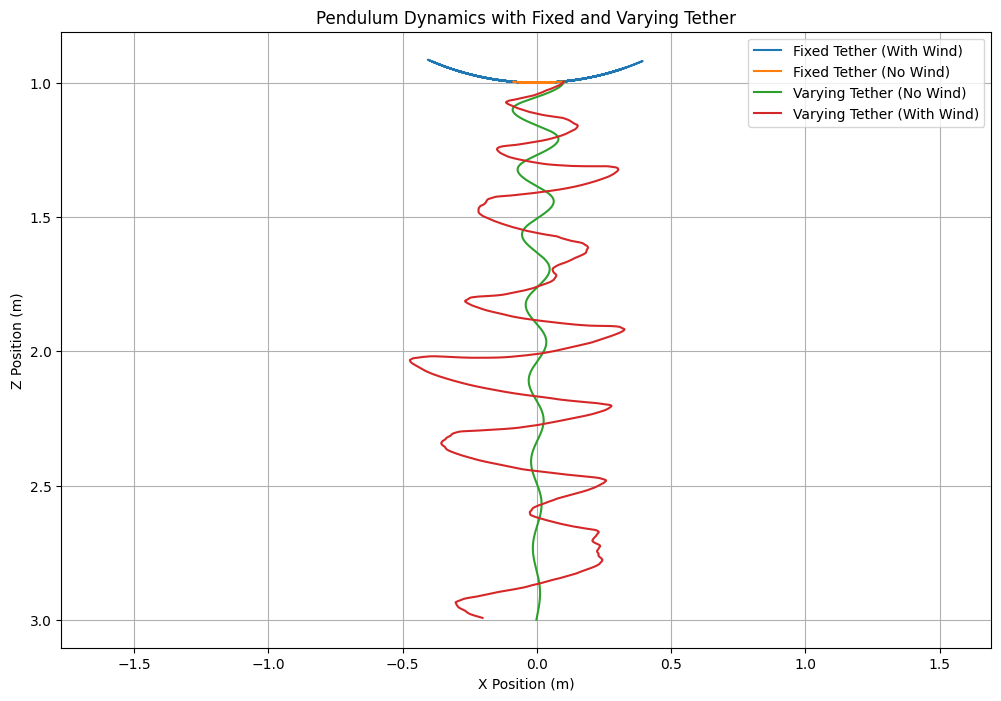

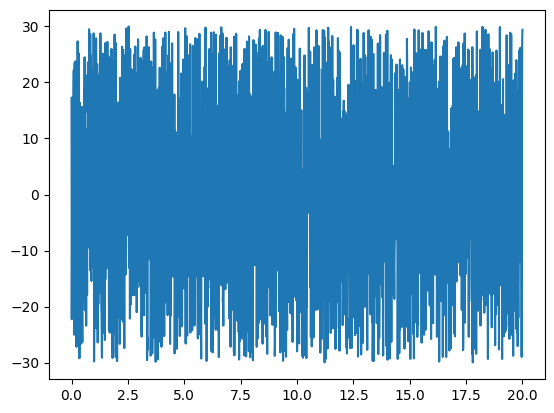

In [161]:
import jax
import jax.numpy as jnp
from jax import random, jit, vmap
import numpy as np
import matplotlib.pyplot as plt

# Set random seed
key = random.PRNGKey(42)

# Define dynamics without JIT first
def dynamics_fixed(x, u, d):
    theta, theta_dot = x
    thrust = u[0]
    v_wind = d[0]
    theta_ddot = (thrust/(m*l0) - g/l0*jnp.sin(theta) + 
                 C_d/(m*l0)*(v_wind - l0*theta_dot))
    return jnp.array([theta_dot, theta_ddot])

def dynamics_varying(x, u, d):
    theta, theta_dot, ell = x
    thrust, ell_dot = u[0], u[1]
    v_wind = d[0]
    theta_ddot = (thrust/(m*ell) - (g/ell)*jnp.sin(theta) - 2*(ell_dot/ell)*theta_dot + 
                (C_d/(m*ell))*(v_wind - (ell_dot*jnp.sin(theta) + ell*jnp.cos(theta)*theta_dot))*jnp.cos(theta))
    return jnp.array([theta_dot, theta_ddot, ell_dot])

# Now JIT compile them
dynamics_fixed_jit = jit(dynamics_fixed)
dynamics_varying_jit = jit(dynamics_varying)

# JIT-compiled RK4 step with static_argnums for the dynamics function
@partial(jit, static_argnums=(0,))
def rk4_step(f, x, u, d, dt):
    k1 = f(x, u, d)
    k2 = f(x + 0.5 * dt * k1, u, d)
    k3 = f(x + 0.5 * dt * k2, u, d)
    k4 = f(x + dt * k3, u, d)
    return x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def simulate_system(dynamics, x0, u, wind_samples, dt, T_sim):
    N = int(T_sim / dt)
    xs = jnp.zeros((N, len(x0)))
    xs = xs.at[0].set(x0)
    
    def step(carry, i):
        x_prev = carry
        d = jnp.array([wind_samples[i]])
        x_next = rk4_step(dynamics, x_prev, u, d, dt)
        return x_next, x_next
    
    _, xs = jax.lax.scan(step, x0, jnp.arange(1, N))
    xs = jnp.concatenate([x0[jnp.newaxis, :], xs], axis=0)
    return xs

# Simulation parameters
dt = 0.01   # Time step (s)
T_sim = 20   # Total simulation time (s)
N = int(T_sim / dt)  # Number of simulation steps

# Generate all wind samples upfront with fixed seed
wind_samples = random.uniform(key, (N,), minval=-v_wind_abs_max, maxval=v_wind_abs_max)

# Initial conditions
x0_fixed = jnp.array([0.1, 0.0])  # [theta, theta_dot]
x0_varying = jnp.array([0.1, 0.0, l0])  # [theta, theta_dot, ell]

# Control inputs
u_fixed = jnp.array([thrust_value])
u_varying = jnp.array([thrust_value, l_dot])

# Run simulations separately (can't JIT compile the whole thing due to different dynamics)
xs_fixed_no_wind = simulate_system(dynamics_fixed_jit, x0_fixed, u_fixed, jnp.zeros(N), dt, T_sim)
xs_varying_no_wind = simulate_system(dynamics_varying_jit, x0_varying, u_varying, jnp.zeros(N), dt, T_sim)
xs_fixed_wind = simulate_system(dynamics_fixed_jit, x0_fixed, u_fixed, wind_samples, dt, T_sim)
xs_varying_wind = simulate_system(dynamics_varying_jit, x0_varying, u_varying, wind_samples, dt, T_sim)

# Convert to numpy for plotting
xs_fixed_no_wind = np.array(xs_fixed_no_wind)
xs_varying_no_wind = np.array(xs_varying_no_wind)
xs_fixed_wind = np.array(xs_fixed_wind)
xs_varying_wind = np.array(xs_varying_wind)

# Rest of your plotting code...

# Plotting (same as before)
def get_xz_trace(theta_array, ell_array):
    x = ell_array * np.sin(theta_array)
    z = ell_array * np.cos(theta_array)
    return x, z

# ... rest of your plotting code ...

theta_fixed_no_wind = xs_fixed_no_wind[:, 0]
ell_fixed_no_wind = l0 * np.ones_like(theta_fixed_no_wind)
x_fixed_no_wind, z_fixed_no_wind = get_xz_trace(theta_fixed_no_wind, ell_fixed_no_wind)

theta_varying_no_wind = xs_varying_no_wind[:, 0]
ell_varying_no_wind = xs_varying_no_wind[:, 2]
x_varying_no_wind, z_varying_no_wind = get_xz_trace(theta_varying_no_wind, ell_varying_no_wind)

theta_fixed_with_wind = xs_fixed_wind[:, 0]
ell_fixed_with_wind = l0 * np.ones_like(theta_fixed_with_wind)
x_fixed_with_wind, z_fixed_with_wind = get_xz_trace(theta_fixed_with_wind, ell_fixed_with_wind)

theta_varying_with_wind = xs_varying_wind[:, 0]
ell_varying_with_wind = xs_varying_wind[:, 2]
x_varying_with_wind, z_varying_with_wind = get_xz_trace(theta_varying_with_wind, ell_varying_with_wind)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x_fixed_with_wind, z_fixed_with_wind, label='Fixed Tether (With Wind)')
plt.plot(x_fixed_no_wind, z_fixed_no_wind, label='Fixed Tether (No Wind)')
plt.plot(x_varying_no_wind, z_varying_no_wind, label='Varying Tether (No Wind)')
plt.plot(x_varying_with_wind, z_varying_with_wind, label='Varying Tether (With Wind)')
plt.title('Pendulum Dynamics with Fixed and Varying Tether')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.xlabel('X Position (m)')
plt.ylabel('Z Position (m)')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(np.linspace(0,T_sim, N),wind_samples, label='Wind Speed Samples')

# Nominal PID controller

In [162]:
from functools import partial
from jax import jit, lax

# Define maximum absolute thrust (modify as needed for your system)
T_max_abs = 10.0  # Maximum absolute thrust value

def PID_controller(dynamics, x0, u, dt, T_final, Kp=5.0, Ki=20.0, Kd=10.0, key=random.PRNGKey(42)):
    N = int(T_final / dt)  # Concrete integer outside JIT
    
    @partial(jit, static_argnames=['dynamics', 'N'])
    def _pid_inner(dynamics, x0, u, dt, Kp, Ki, Kd, key, N):
        # Generate all wind samples upfront
        wind_samples = random.uniform(key, (N,), minval=-v_wind_abs_max, maxval=v_wind_abs_max)
        
        def pid_step(carry, i):
            x, integral, prev_error = carry
            v_wind = wind_samples[i]
            d = jnp.array([v_wind])
            
            # PID calculations
            error = -x[0]
            integral = jnp.clip(integral + error * dt, -1.0, 1.0)  # Anti-windup
            derivative = (error - prev_error) / dt
            u_pid = Kp * error + Ki * integral + Kd * derivative
            
            # Clip thrust command to [-T_max_abs, T_max_abs]
            u_pid = jnp.clip(u_pid, -T_max_abs, T_max_abs)
            
            # Update control
            u_control = u.at[0].set(u_pid)
            
            # Step dynamics
            x_next = rk4_step(dynamics, x, u_control, d, dt)
            
            # Store results
            return (x_next, integral, error), (x_next, u_pid, error)
        
        # Initialize
        init_state = (x0, 0.0, 0.0)
        
        # Run simulation with scan
        _, (state_history, control_history, error_history) = lax.scan(
            pid_step,
            init_state,
            jnp.arange(N)
        )
        
        # Prepend initial state
        state_history = jnp.concatenate([x0[jnp.newaxis], state_history])
        control_history = jnp.concatenate([jnp.array([0.0]), control_history])
        error_history = jnp.concatenate([jnp.array([0.0]), error_history])
        
        return state_history, control_history, error_history, wind_samples
    
    return _pid_inner(dynamics, x0, u, dt, Kp, Ki, Kd, key, N)

# JIT-compiled RK4 step with static_argnums
@partial(jit, static_argnums=(0,))
def rk4_step(f, x, u, d, dt):
    k1 = f(x, u, d)
    k2 = f(x + 0.5 * dt * k1, u, d)
    k3 = f(x + 0.5 * dt * k2, u, d)
    k4 = f(x + dt * k3, u, d)
    return x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# JIT-compiled dynamics
dynamics_fixed_jit = jit(dynamics_fixed)
dynamics_varying_jit = jit(dynamics_varying)

# Run PID simulations with thrust clipping
pid_fixed_states, pid_fixed_controls, pid_fixed_error_history, pid_wind = PID_controller(
    dynamics_fixed_jit, 
    jnp.array([0.1, -0.05]), 
    jnp.array([0.0]), 
    dt=dt,
    T_final=T_sim
)

pid_varying_states, pid_varying_controls, pid_varying_error_history, _ = PID_controller(
    dynamics_varying_jit,
    jnp.array([0.1, -0.05, l0]),
    jnp.array([0.0, l_dot]),
    dt=dt,
    T_final=T_sim
)

In [163]:
# import jax
# import jax.numpy as jnp
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.linalg import solve_continuous_are
# from functools import partial

# # Your linearization function
# @partial(jax.jit, static_argnames=["dynamics"])
# def linearize(dynamics, state, control, disturbance):
#     A, B = jax.jacobian(dynamics, [0, 1])(state, control, disturbance)
#     C = dynamics(state, control, disturbance) - A @ state - B @ control
#     return A, B, C

# def lqr_continuous(A, B, Q, R):
#     """Robust continuous-time LQR implementation"""
#     try:
#         # Regularization for numerical stability
#         Q_reg = Q + 1e-6*np.eye(Q.shape[0])
#         R_reg = R + 1e-6*np.eye(R.shape[0])
#         P = solve_continuous_are(A, B, Q_reg, R_reg)
#         return np.linalg.inv(R_reg) @ B.T @ P
#     except Exception as e:
#         print(f"LQR failed: {str(e)}")
#         return None

# def simulate_system(dynamics, x0, wind_samples, dt, T_final, Q, R):
#     N = len(wind_samples)
#     n_states = len(x0)
#     n_controls = R.shape[0]  # Infer number of controls from R matrix
    
#     state_history = jnp.zeros((N, n_states))
#     control_history = jnp.zeros((N, n_controls))
    
#     # Initialize with first state and zero control
#     x = x0.copy()
#     u_prev = jnp.zeros(n_controls)
#     d_prev = jnp.array([wind_samples[0]])
    
#     for i in range(N):
#         # Current disturbance
#         d = jnp.array([wind_samples[i]])
        
#         # Linearize about previous (x, u, d)
#         A, B, _ = linearize(dynamics, x, u_prev, d_prev)
#         A, B = np.array(A), np.array(B)
        
#         # Compute LQR gain
#         K = lqr_continuous(A, B, Q, R)
        
#         if K is not None:
#             u = -K @ x
#             # Different bounds for thrust vs length rate
#             if n_controls == 1:
#                 u = jnp.clip(u, -10.0, 10.0)
#             else:
#                 u = jnp.clip(u, jnp.array([-10.0, -1.0]), jnp.array([10.0, 1.0]))
#         else:
#             # Fallback PD controller
#             K_p, K_d = 1.0, 0.5
#             if n_controls == 1:
#                 u = jnp.array([-K_p*x[0] - K_d*x[1]])
#             else:
#                 u = jnp.array([-K_p*x[0] - K_d*x[1], 0.0])
        
#         # Store results
#         control_history = control_history.at[i,:].set(u)
#         x = rk4_step(dynamics, x, u, d, dt)
#         state_history = state_history.at[i,:].set(x)
        
#         # Update for next linearization
#         u_prev = u
#         d_prev = d
    
#     return np.array(state_history), np.array(control_history)

# # Fixed-length pendulum (2 states, 1 control)
# Q_fixed = np.diag([10.0, 1.0])
# R_fixed = np.array([[0.1]])
# lqr_fixed_states, lqr_fixed_controls = simulate_system(
#     dynamics_fixed,
#     jnp.array([0.1, -0.05]),
#     pid_wind, dt, T_sim,
#     Q_fixed, R_fixed
# )

# # Varying-length pendulum (3 states, 2 controls)
# Q_varying = np.diag([10.0, 1.0, 0.1])
# R_varying = np.diag([0.1, 0.1])
# lqr_varying_states, lqr_varying_controls = simulate_system(
#     dynamics_varying,
#     jnp.array([0.1, -0.05, l0]),
#     pid_wind, dt, T_sim,
#     Q_varying, R_varying
# )

# # Output verification
# print("Fixed-length results:")
# print(f"States shape: {lqr_fixed_states.shape}")  # Should be (N, 2)
# print(f"Controls shape: {lqr_fixed_controls.shape}")  # Should be (N, 1)

# print("\nVarying-length results:")
# print(f"States shape: {lqr_varying_states.shape}")  # Should be (N, 3)
# print(f"Controls shape: {lqr_varying_controls.shape}")  # Should be (N, 2)

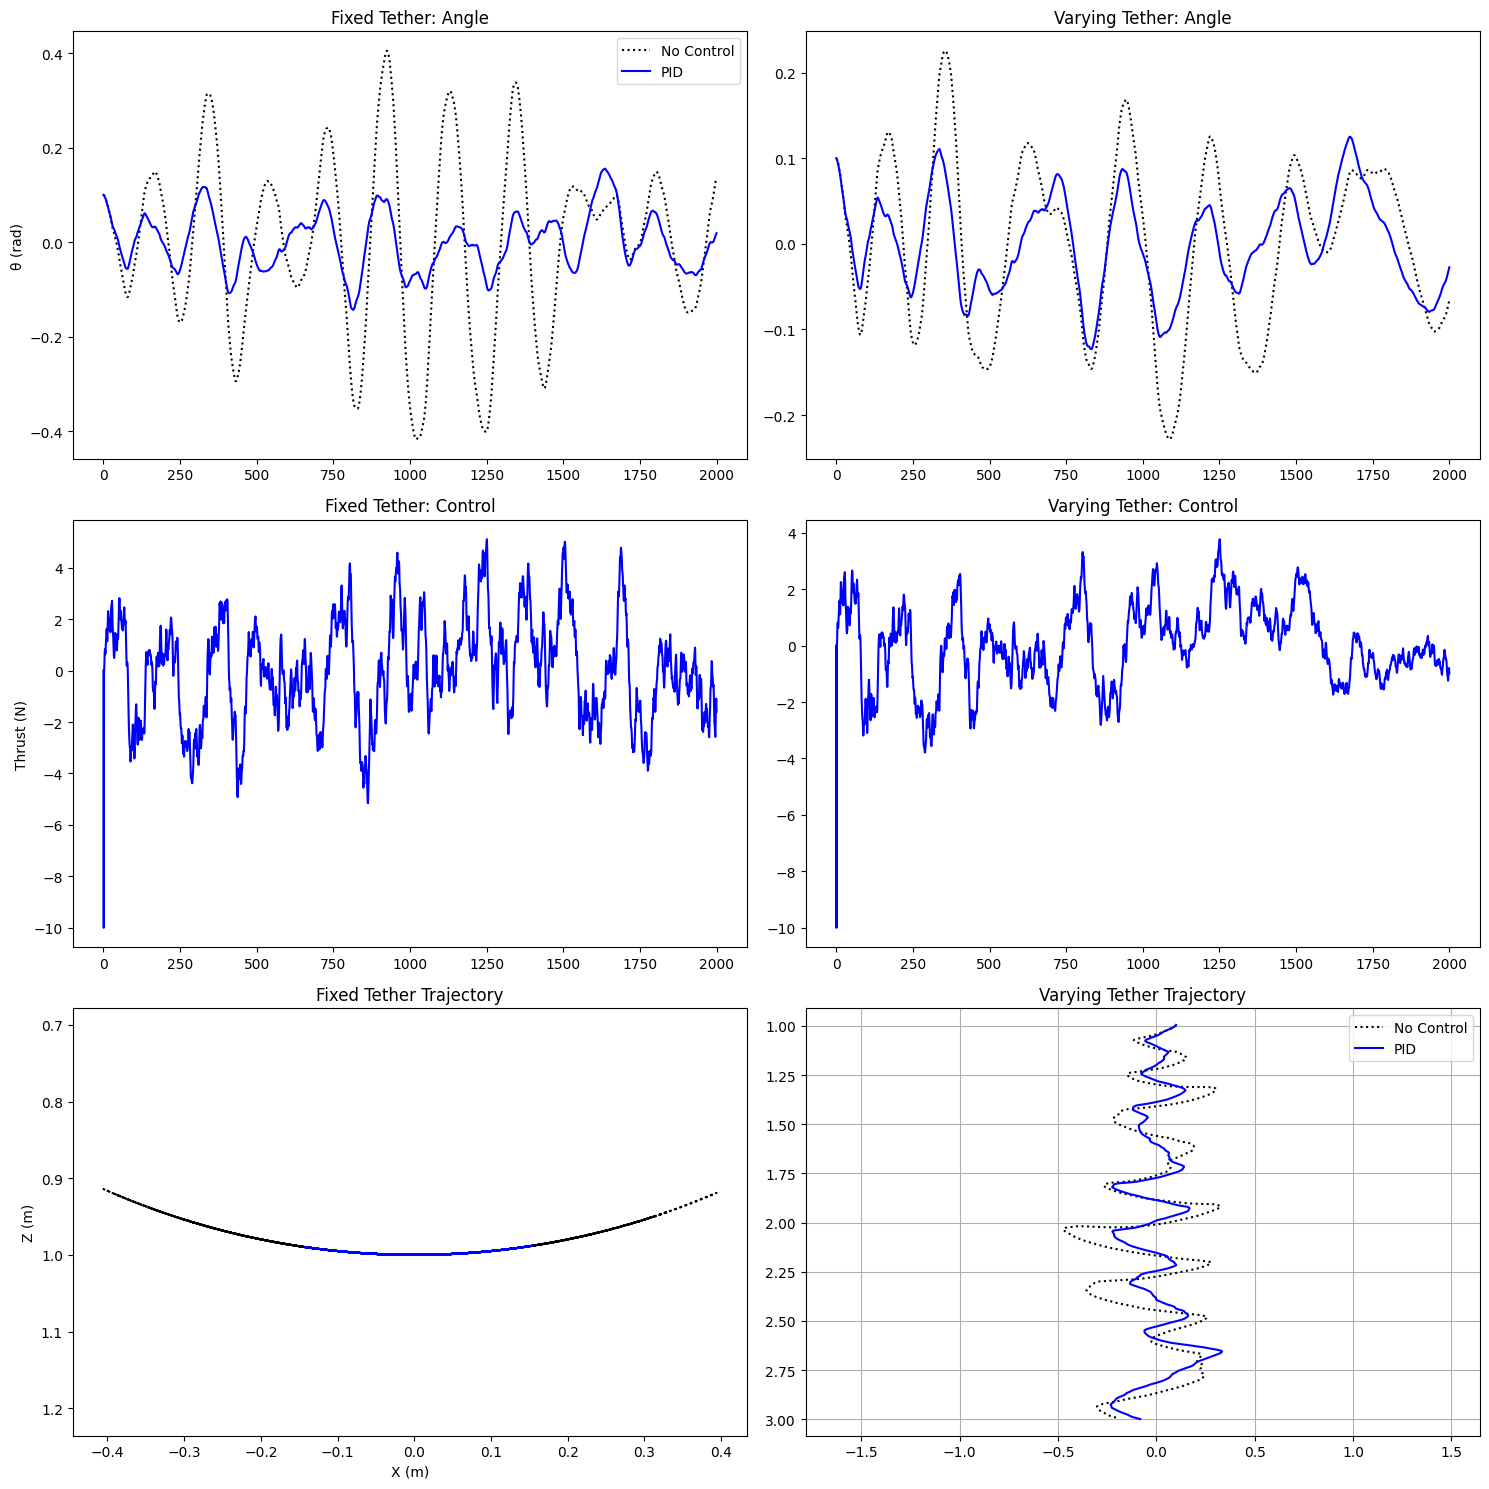

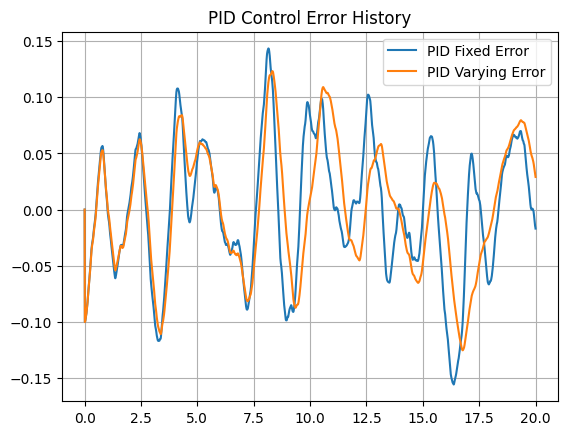

In [164]:
# Comparative Plotting
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Angle responses
axs[0,0].plot(xs_fixed_wind[:,0], 'k:', label='No Control')
axs[0,0].plot(pid_fixed_states[:,0], 'b-', label='PID')
# axs[0,0].plot(lqr_fixed_states[:,0], 'r--', label='LQR')
axs[0,0].set_title('Fixed Tether: Angle')
axs[0,0].set_ylabel('θ (rad)')
axs[0,0].legend()

axs[0,1].plot(xs_varying_wind[:,0], 'k:')
axs[0,1].plot(pid_varying_states[:,0], 'b-')
# axs[0,1].plot(lqr_varying_states[:,0], 'r--')
axs[0,1].set_title('Varying Tether: Angle')

# Control inputs
axs[1,0].plot(pid_fixed_controls, 'b-')
# axs[1,0].plot(lqr_fixed_controls, 'r--')
axs[1,0].set_title('Fixed Tether: Control')
axs[1,0].set_ylabel('Thrust (N)')

axs[1,1].plot(pid_varying_controls, 'b-')
# axs[1,1].plot(lqr_varying_controls, 'r--')
axs[1,1].set_title('Varying Tether: Control')

# Trajectories
def plot_traj(ax, theta, l, color, label):
    x, z = l*np.sin(theta), l*np.cos(theta)
    ax.plot(x, z, color, label=label)
    ax.invert_yaxis()
    ax.axis('equal')

plot_traj(axs[2,0], xs_fixed_wind[:,0], l0, 'k:', 'No Control')
plot_traj(axs[2,0], pid_fixed_states[:,0], l0, 'b-', 'PID')
# plot_traj(axs[2,0], lqr_fixed_states[:,0], l0, 'r--', 'LQR')
axs[2,0].set_title('Fixed Tether Trajectory')
axs[2,0].set_xlabel('X (m)')
axs[2,0].set_ylabel('Z (m)')
axs[2,0].invert_yaxis()

plot_traj(axs[2,1], xs_varying_wind[:,0], xs_varying_wind[:,2], 'k:', 'No Control')
plot_traj(axs[2,1], pid_varying_states[:,0], pid_varying_states[:,2], 'b-', 'PID')
# plot_traj(axs[2,1], lqr_varying_states[:,0], lqr_varying_states[:,2], 'r--', 'LQR')
axs[2,1].set_title('Varying Tether Trajectory')
axs[2,1].invert_yaxis()

plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(np.linspace(0, T_sim, N+1), pid_fixed_error_history, label='PID Fixed Error')
plt.plot(np.linspace(0, T_sim, N+1), pid_varying_error_history, label='PID Varying Error')
plt.title('PID Control Error History')
plt.grid()
plt.legend()

# CBF Safety Filter Controller

In [165]:
# import cvxpy as cp
# import jax
# import jax.numpy as jnp
# from jax import random
# import matplotlib.pyplot as plt

# # System parameters
# m = 1.0       # Mass [kg]
# l0 = 1.0      # Tether length [m]
# g = 9.81      # Gravity [m/s²]
# C_d = 0.1     # Drag coefficient
# T_max_abs = 10.0  # Max thrust [N]

# # Safety parameters
# theta_max = 0.2  # Max safe angle [rad]
# alpha = 2.0      # CBF convergence rate
# epsilon = 0.1    # Robustness tuning

# # =============================================
# # 1. CBF Formulation (Fixed)
# # =============================================
# def h(x):
#     """CBF: h(x) >= 0 means safe (|θ| < θ_max)"""
#     return theta_max**2 - x[0]**2

# def dh_dx(x):
#     """Gradient of CBF: [∂h/∂θ, ∂h/∂θ̇]"""
#     return jnp.array([-2 * x[0], 0.0])

# def cbf_safety_filter(x, u_nominal, Lfh, Lgh):
#     """
#     ISSf-CBF-QP using CVXPY
#     Args:
#         x: State [θ, θ̇]
#         u_nominal: PID output
#         Lfh: Lie derivative L_f h(x)
#         Lgh: Lie derivative L_g h(x) (scalar)
#     """
#     # CVXPY QP setup
#     u = cp.Variable()
#     objective = cp.Minimize(cp.sum_squares(u - u_nominal))
#     constraints = [
#         Lfh + Lgh * u + alpha * h(x) - (1/epsilon) * Lgh**2 >= 0,
#         u >= -T_max_abs,
#         u <= T_max_abs
#     ]
#     prob = cp.Problem(objective, constraints)
#     prob.solve()
    
#     return u.value

# # =============================================
# # 2. Nominal PID Controller (Fixed)
# # =============================================
# def pid_controller(x, integral, prev_error, dt, Kp=5.0, Ki=20.0, Kd=10.0):
#     """Standard PID controller for angle regulation"""
#     error = -x[0]  # Regulate θ → 0
#     integral = jnp.clip(integral + error * dt, -1.0, 1.0)  # Anti-windup
#     derivative = (error - prev_error) / dt
#     u_pid = Kp * error + Ki * integral + Kd * derivative
#     return u_pid, integral, error

# # =============================================
# # 3. Combined CBF-PID Simulation (Fixed)
# # =============================================
# def simulate_cbf_pid(dynamics, x0, dt, T_final):
#     N = int(T_final / dt)
#     xs = jnp.zeros((N+1, 2))
#     us = jnp.zeros(N)
#     xs = xs.at[0].set(x0)
    
#     integral = 0.0
#     prev_error = 0.0
#     key = random.PRNGKey(42)
    
#     for i in range(N):
#         x = xs[i]
#         key, subkey = random.split(key)
        
#         # 1. Compute nominal PID control
#         u_pid, integral, prev_error = pid_controller(x, integral, prev_error, dt)
        
#         # 2. Compute Lie derivatives for CBF
#         A, B, _ = linearize(dynamics, x, jnp.array([0.0]), jnp.array([0.0]))
#         dh = dh_dx(x)
#         Lfh = float(dh @ (A @ x))  # Convert to Python float for CVXPY
#         Lgh = float(dh @ B[:, 0])  # Convert to Python float for CVXPY
        
#         # 3. Apply CBF safety filter
#         u_safe = cbf_safety_filter(x, float(u_pid), Lfh, Lgh)
        
#         # 4. Step dynamics (with random wind disturbance)
#         d = jnp.array([random.uniform(subkey, minval=-2.0, maxval=2.0)])
#         xs = xs.at[i+1].set(rk4_step(dynamics, x, jnp.array([u_safe]), d, dt))
#         us = us.at[i].set(u_safe)
    
#     return xs, us

# # =============================================
# # 4. Dynamics and Helper Functions
# # =============================================
# def dynamics_fixed(x, u, d):
#     theta, theta_dot = x
#     thrust = u[0]
#     v_wind = d[0]
#     theta_ddot = (thrust/(m*l0) - g/l0*jnp.sin(theta) + C_d/(m*l0)*(v_wind - l0*theta_dot))
#     return jnp.array([theta_dot, theta_ddot])

# def rk4_step(f, x, u, d, dt):
#     k1 = f(x, u, d)
#     k2 = f(x + 0.5*dt*k1, u, d)
#     k3 = f(x + 0.5*dt*k2, u, d)
#     k4 = f(x + dt*k3, u, d)
#     return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# def linearize(dynamics, x, u, d):
#     A = jax.jacfwd(dynamics, 0)(x, u, d)  # df/dx
#     B = jax.jacfwd(dynamics, 1)(x, u, d)  # df/du
#     c = dynamics(x, u, d) - A @ x - B @ u
#     return A, B, c

# # =============================================
# # 5. Run and Visualize
# # =============================================
# x0 = jnp.array([0.1, -0.05])  # Initial [θ, θ̇]
# xs, us = simulate_cbf_pid(dynamics_fixed, x0, dt=0.01, T_final=10.0)

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(xs[:, 0], label='θ [rad]')
# plt.plot(pid_fixed_states[:, 0], 'k--', label='PID θ [rad]')
# plt.axhline(y=theta_max, color='r', linestyle='--', label='Safety bounds')
# plt.axhline(y=-theta_max, color='r', linestyle='--')
# plt.legend()
# plt.title('Pendulum Angle')

# plt.subplot(1, 2, 2)
# plt.plot(us, label='Thrust [N]')
# plt.axhline(y=T_max_abs, color='r', linestyle='--', label='Control limits')
# plt.axhline(y=-T_max_abs, color='r', linestyle='--')
# plt.legend()
# plt.title('Control Input')
# plt.tight_layout()
# plt.show()

In [166]:
# import cvxpy as cp
# import jax
# import jax.numpy as jnp
# from jax import random
# import matplotlib.pyplot as plt

# # System parameters
# m = 1.0       # Mass [kg]
# l0 = 1.0      # Tether length [m]
# g = 9.81      # Gravity [m/s²]
# C_d = 0.1     # Drag coefficient
# T_max_abs = 10.0  # Max thrust [N]

# # Safety parameters
# theta_max = 0.5  # Max safe angle [rad]
# alpha = 2.0      # CBF convergence rate
# epsilon = 0.1    # Robustness tuning

# # =============================================
# # 1. CBF Formulation
# # =============================================
# def h(x):
#     """CBF: h(x) >= 0 means safe (|θ| < θ_max)"""
#     return theta_max**2 - x[0]**2

# def dh_dx(x):
#     """Gradient of CBF: [∂h/∂θ, ∂h/∂θ̇]"""
#     return jnp.array([-2 * x[0], 0.0])

# def cbf_safety_filter(x, u_nominal, Lfh, Lgh):
#     """
#     ISSf-CBF-QP using CVXPY
#     Args:
#         x: State [θ, θ̇]
#         u_nominal: PID output
#         Lfh: Lie derivative L_f h(x)
#         Lgh: Lie derivative L_g h(x) (scalar)
#     """
#     u = cp.Variable()
#     objective = cp.Minimize(cp.sum_squares(u - u_nominal))
#     constraints = [
#         Lfh + Lgh * u + alpha * h(x) - (1/epsilon) * Lgh**2 >= 0,
#         u >= -T_max_abs,
#         u <= T_max_abs
#     ]
#     prob = cp.Problem(objective, constraints)
#     prob.solve()
#     return u.value

# # =============================================
# # 2. Controllers
# # =============================================
# def pid_controller(x, integral, prev_error, dt, Kp=5.0, Ki=20.0, Kd=10.0):
#     """Standard PID controller for angle regulation"""
#     error = -x[0]  # Regulate θ → 0
#     integral = jnp.clip(integral + error * dt, -1.0, 1.0)  # Anti-windup
#     derivative = (error - prev_error) / dt
#     u_pid = Kp * error + Ki * integral + Kd * derivative
#     return jnp.array([u_pid]), integral, error  # Return as array

# def pid_cbf_controller(x, integral, prev_error, dt):
#     """PID with CBF safety filter"""
#     u_pid, integral, prev_error = pid_controller(x, integral, prev_error, dt)
    
#     # Compute Lie derivatives
#     A, B, _ = linearize(dynamics_fixed, x, jnp.array([0.0]), jnp.array([0.0]))
#     dh = dh_dx(x)
#     Lfh = float(dh @ (A @ x))
#     Lgh = float(dh @ B[:, 0])
    
#     # Apply safety filter
#     u_safe = cbf_safety_filter(x, float(u_pid[0]), Lfh, Lgh)  # Access scalar value
#     return jnp.array([u_safe]), integral, prev_error  # Return as array

# def no_control(x, integral, prev_error, dt):
#     """Zero control input"""
#     return jnp.array([0.0]), integral, prev_error  # Return as array

# # =============================================
# # 3. Simulation Functions
# # =============================================
# def simulate(dynamics, x0, controller_fn, dt, T_final):
#     N = int(T_final / dt)
#     xs = jnp.zeros((N+1, 2))
#     us = jnp.zeros((N, 1))  # Control outputs are shape (1,)
#     xs = xs.at[0].set(x0)
    
#     integral = 0.0
#     prev_error = 0.0
#     key = random.PRNGKey(42)
    
#     for i in range(N):
#         x = xs[i]
#         key, subkey = random.split(key)
        
#         # Get control input (already an array)
#         u, integral, prev_error = controller_fn(x, integral, prev_error, dt)
        
#         # Step dynamics with random wind disturbance
#         d = jnp.array([random.uniform(subkey, minval=-2.0, maxval=2.0)])
#         xs = xs.at[i+1].set(rk4_step(dynamics, x, u, d, dt))
#         us = us.at[i].set(u)
    
#     return xs, us

# # =============================================
# # 4. Dynamics and Helpers
# # =============================================
# @jax.jit
# def dynamics_fixed(x, u, d):
#     theta, theta_dot = x
#     thrust = u[0]  # u is always shape (1,)
#     v_wind = d[0]
#     theta_ddot = (thrust/(m*l0) - g/l0*jnp.sin(theta) + C_d/(m*l0)*(v_wind - l0*theta_dot))
#     return jnp.array([theta_dot, theta_ddot])

# def rk4_step(f, x, u, d, dt):
#     k1 = f(x, u, d)
#     k2 = f(x + 0.5*dt*k1, u, d)
#     k3 = f(x + 0.5*dt*k2, u, d)
#     k4 = f(x + dt*k3, u, d)
#     return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# def linearize(dynamics, x, u, d):
#     A = jax.jacfwd(dynamics, 0)(x, u, d)  # df/dx
#     B = jax.jacfwd(dynamics, 1)(x, u, d)  # df/du
#     c = dynamics(x, u, d) - A @ x - B @ u
#     return A, B, c

# # =============================================
# # 5. Run Comparison
# # =============================================
# def run_comparison():
#     x0 = jnp.array([0.1, -0.05])  # Initial [θ, θ̇]
#     dt, T_final = 0.01, 10.0
    
#     print("Running no control...")
#     xs_noctrl, _ = simulate(dynamics_fixed, x0, no_control, dt, T_final)
#     print("Running PID only...")
#     xs_pid, us_pid = simulate(dynamics_fixed, x0, pid_controller, dt, T_final)
#     print("Running PID+CBF...")
#     xs_pidcbf, us_pidcbf = simulate(dynamics_fixed, x0, pid_cbf_controller, dt, T_final)
    
#     # Plotting
#     plt.figure(figsize=(15, 5))
    
#     # Angle comparison
#     plt.subplot(1, 3, 1)
#     plt.plot(xs_noctrl[:, 0], 'k-', label='No control')
#     plt.plot(xs_pid[:, 0], 'b-', label='PID only')
#     plt.plot(xs_pidcbf[:, 0], 'r-', label='PID+CBF')
#     plt.axhline(y=theta_max, color='r', linestyle='--', alpha=0.5)
#     plt.axhline(y=-theta_max, color='r', linestyle='--', alpha=0.5)
#     plt.ylabel('θ [rad]')
#     plt.title('Angle Trajectories')
#     plt.legend()
    
#     # Control input comparison
#     plt.subplot(1, 3, 2)
#     plt.plot(us_pid[:, 0], 'b-', label='PID only')  # Access scalar values
#     plt.plot(us_pidcbf[:, 0], 'r-', label='PID+CBF')  # Access scalar values
#     plt.axhline(y=T_max_abs, color='k', linestyle='--', alpha=0.5)
#     plt.axhline(y=-T_max_abs, color='k', linestyle='--', alpha=0.5)
#     plt.ylabel('Thrust [N]')
#     plt.title('Control Inputs')
#     plt.legend()
    
#     # Phase portrait
#     plt.subplot(1, 3, 3)
#     plt.plot(xs_noctrl[:, 0], xs_noctrl[:, 1], 'k-', label='No control')
#     plt.plot(xs_pid[:, 0], xs_pid[:, 1], 'b-', label='PID only')
#     plt.plot(xs_pidcbf[:, 0], xs_pidcbf[:, 1], 'r-', label='PID+CBF')
#     plt.xlabel('θ [rad]')
#     plt.ylabel('θ̇ [rad/s]')
#     plt.title('Phase Portrait')
#     plt.legend()
    
#     plt.tight_layout()
#     plt.show()

# run_comparison()

In [167]:
# theta_max = 0.11
# # =============================================
# # 4. Dynamics and Helpers
# # =============================================
# @jax.jit
# def dynamics_fixed(x, u, d):
#     theta, theta_dot = x
#     thrust = u[0]  # u is always shape (1,)
#     v_wind = d[0]
#     theta_ddot = (thrust/(m*l0) - g/l0*jnp.sin(theta) + C_d/(m*l0)*(v_wind - l0*theta_dot))
#     return jnp.array([theta_dot, theta_ddot])

# def rk4_step(f, x, u, d, dt):
#     k1 = f(x, u, d)
#     k2 = f(x + 0.5*dt*k1, u, d)
#     k3 = f(x + 0.5*dt*k2, u, d)
#     k4 = f(x + dt*k3, u, d)
#     return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# def linearize(dynamics, x, u, d):
#     A = jax.jacfwd(dynamics, 0)(x, u, d)  # df/dx
#     B = jax.jacfwd(dynamics, 1)(x, u, d)  # df/du
#     c = dynamics(x, u, d) - A @ x - B @ u
#     return A, B, c

# # =============================================
# # 1. CBF Formulation
# # =============================================
# def h(x):
#     """CBF: h(x) >= 0 means safe (|θ| < θ_max)"""
#     return theta_max**2 - x[0]**2

# def dh_dx(x):
#     """Gradient of CBF: [∂h/∂θ, ∂h/∂θ̇]"""
#     return jnp.array([-2 * x[0], 0.0])

# def cbf_safety_filter(x, u_nominal, Lfh, Lgh, delta=2.0):
#     """Improved ISSf-CBF-QP with proper margins"""
#     u = cp.Variable()
    
#     # Calculate safety margin from disturbance bound
#     safety_margin = max(0, -alpha**(-1)(-(epsilon * delta**2)/4))
    
#     # Handle small control gain cases
#     if abs(Lgh) < 1e-3:
#         constraints = [
#             Lfh + Lgh * u + alpha * h(x) >= 0,
#             u >= -T_max_abs,
#             u <= T_max_abs
#         ]
#     else:
#         constraints = [
#             Lfh + Lgh * u + alpha * (h(x) + safety_margin) >= (1/epsilon) * Lgh**2,
#             u >= -T_max_abs,
#             u <= T_max_abs
#         ]
    
#     prob = cp.Problem(cp.Minimize(cp.sum_squares(u - u_nominal)),
#                      constraints)
#     try:
#         prob.solve()
#         if prob.status not in ["optimal", "optimal_inaccurate"]:
#             raise ValueError("QP not solved optimally")
#         return float(u.value)
#     except:
#         return np.clip(u_nominal, -T_max_abs, T_max_abs)

# # Use the reference implementation of CBF-PID that works correctly
# def pid_cbf_controller(x, integral, prev_error, dt):
#     """Stable PID with CBF safety filter (reference implementation)"""
#     # 1. Compute nominal PID control (with same parameters as your PID)
#     error = -x[0]
#     integral = jnp.clip(integral + error * dt, -1.0, 1.0)  # Same anti-windup
#     derivative = (error - prev_error) / dt
#     u_pid = 5.0 * error + 20.0 * integral + 10.0 * derivative  # Same gains
    
#     # 2. Compute CBF terms using your linearize function
#     A, B, _ = linearize(dynamics_fixed, x, jnp.array([0.0]), jnp.array([0.0]))
#     dh = jnp.array([-2*x[0], 0.0])
    
#     # Convert to numpy floats for CVXPY (more stable than direct float conversion)
#     x_np = jax.device_get(x)
#     u_pid_np = float(jax.device_get(u_pid))
#     Lfh = float(jax.device_get(dh @ (A @ x)))
#     Lgh = float(jax.device_get(dh @ B[:,0]))
    
#     # 3. Apply safety filter with error handling
#     try:
#         u_safe = cbf_safety_filter(x_np, u_pid_np, Lfh, Lgh)
#         if u_safe is None:  # Handle QP failures
#             print(f"QP error, using nominal control: {error}")
#             u_safe = np.clip(u_pid_np, -T_max_abs, T_max_abs)
#     except:
#         # print error to allow debugging
#         print(f"QP error, using nominal control: {error}")
#         u_safe = np.clip(u_pid_np, -T_max_abs, T_max_abs)
    
#     return jnp.array([u_safe]), integral, error

# # Run the stable PID+CBF simulation
# pidcbf_states = jnp.zeros_like(pid_fixed_states)
# pidcbf_controls = jnp.zeros_like(pid_fixed_controls)
# pidcbf_states = pidcbf_states.at[0].set(jnp.array([0.1, -0.05]))
# integral = 0.0
# prev_error = 0.0

# for i in range(len(pid_fixed_controls)):
#     x = pidcbf_states[i]
#     d = jnp.array([pid_wind[i]])  # Using same wind sequence
    
#     u, integral, prev_error = pid_cbf_controller(x, integral, prev_error, dt)
#     pidcbf_states = pidcbf_states.at[i+1].set(rk4_step(dynamics_fixed_jit, x, u, d, dt))
#     pidcbf_controls = pidcbf_controls.at[i].set(u[0])


In [168]:
# import jax.numpy as jnp
# from jax import jit, grad, lax, random
# from functools import partial

# from functools import partial
# from jax import jit, lax, grad, random
# import jax.numpy as jnp

# # Define max thrust
# T_max_abs = 10.0

# # Ellipsoidal CBF: theta in [-0.2, 0.2]
# def h(x):
#     return 0.04 - x[0] ** 2  # x[0] is theta

# # Safe filter using a simple projected gradient descent and CBF
# def cbf_safe_filter(f, g, h, x, u_nom, kappa=1.0, epsilon=0.1, u_bounds=(-T_max_abs, T_max_abs)):
#     Lf_h = jnp.dot(grad(h)(x), f(x))
#     Lg_h = jnp.dot(grad(h)(x), g(x))
#     Lg_norm_sq = jnp.dot(Lg_h, Lg_h)
#     rhs = -kappa * h(x) + (1.0 / epsilon) * Lg_norm_sq

#     def objective(u):
#         return jnp.sum((u - u_nom)**2)

#     def constraint(u):
#         return jnp.dot(Lg_h, u) + Lf_h - rhs

#     def projected_update(u):
#         adjustment = 0.1 * (Lg_h / (jnp.linalg.norm(Lg_h) ** 2 + 1e-6)) * (rhs - jnp.dot(Lg_h, u) - Lf_h)
#         return u + adjustment

#     u = u_nom
#     for _ in range(10):
#         u = lax.cond(
#             constraint(u) < 0,
#             projected_update,
#             lambda u: u,
#             u
#         )
#         u = jnp.clip(u, u_bounds[0], u_bounds[1])
    
#     return u

# # RK4 integrator
# @partial(jit, static_argnums=(0,))
# def rk4_step(f, x, u, d, dt):
#     k1 = f(x, u, d)
#     k2 = f(x + 0.5 * dt * k1, u, d)
#     k3 = f(x + 0.5 * dt * k2, u, d)
#     k4 = f(x + dt * k3, u, d)
#     return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# # CBF+PID Controller wrapper
# def CBF_PID_controller(dynamics, x0, u, dt, T_final, Kp=5.0, Ki=20.0, Kd=10.0, key=random.PRNGKey(42)):
#     N = int(T_final / dt)

#     @partial(jit, static_argnames=['dynamics', 'N'])
#     def _pid_inner(dynamics, x0, u, dt, Kp, Ki, Kd, key, N):
#         wind_samples = random.uniform(key, (N,), minval=-v_wind_abs_max, maxval=v_wind_abs_max)

#         def safe_pid_step(carry, i):
#             x, integral, prev_error = carry
#             v_wind = wind_samples[i]
#             d = jnp.array([v_wind])

#             error = -x[0]
#             integral = jnp.clip(integral + error * dt, -1.0, 1.0)
#             derivative = (error - prev_error) / dt
#             u_pid = Kp * error + Ki * integral + Kd * derivative
#             u_pid = jnp.clip(u_pid, -T_max_abs, T_max_abs)

#             u_safe = cbf_safe_filter(f, g, h, x, u_pid)
#             u_control = u.at[0].set(u_safe)

#             x_next = rk4_step(dynamics, x, u_control, d, dt)

#             return (x_next, integral, error), (x_next, u_safe, error)

#         init_state = (x0, 0.0, 0.0)
#         _, (state_hist, control_hist, error_hist) = lax.scan(safe_pid_step, init_state, jnp.arange(N))

#         state_hist = jnp.concatenate([x0[jnp.newaxis], state_hist])
#         control_hist = jnp.concatenate([jnp.array([0.0]), control_hist])
#         error_hist = jnp.concatenate([jnp.array([0.0]), error_hist])

#         return state_hist, control_hist, error_hist, wind_samples

#     return _pid_inner(dynamics, x0, u, dt, Kp, Ki, Kd, key, N)


# # Compile dynamics
# dynamics_fixed_jit = jit(dynamics_fixed)

# # Initial conditions
# l0 = 1.0
# l_dot = 0.0

# CBF_pid_fixed_states, CBF_pid_fixed_controls, CBF_pid_fixed_error_history, CBF_pid_wind = CBF_PID_controller(
#     dynamics_fixed_jit,
#     jnp.array([0.1, -0.05]),
#     jnp.array([0.0]),
#     dt=dt,
#     T_final=T_sim
# )


In [169]:
import jax.numpy as jnp
from jax import jit, grad, lax, random
from functools import partial

# Constants
T_max_abs = 10.0
v_wind_abs_max = 2.0  # Example wind magnitude
dt = 0.01
T_sim = 200

# CBF: Safe set is θ in [-0.2, 0.2]
def h(x):
    return 0.04 - x[0]**2

# Dynamics for testing (inverted pendulum-like)
def dynamics_fixed(x, u, d):
    θ, θ_dot = x
    v_wind = d[0]
    I = 1.0  # moment of inertia
    θ_ddot = (u[0] - v_wind) / I
    return jnp.array([θ_dot, θ_ddot])

# Drift and control vector fields
def f(x):
    return dynamics_fixed(x, jnp.array([0.0]), jnp.array([0.0]))

def g(x):
    return dynamics_fixed(x, jnp.array([1.0]), jnp.array([0.0])) - f(x)

# Ellipsoidal CBF-safe filter
def cbf_safe_filter(f, g, h, x, u_nom, kappa=1.0, epsilon=0.1, u_bounds=(-T_max_abs, T_max_abs)):
    Lf_h = jnp.dot(grad(h)(x), f(x))
    Lg_h = jnp.dot(grad(h)(x), g(x))
    Lg_norm_sq = jnp.dot(Lg_h, Lg_h)
    rhs = -kappa * h(x) + (1.0 / epsilon) * Lg_norm_sq

    def constraint(u):
        return jnp.dot(Lg_h, u) + Lf_h - rhs

    def projected_update(u):
        adjustment = 0.1 * (Lg_h / (jnp.linalg.norm(Lg_h)**2 + 1e-6)) * (rhs - jnp.dot(Lg_h, u) - Lf_h)
        return u + adjustment

    u = u_nom
    for _ in range(10):
        u = lax.cond(constraint(u) < 0, projected_update, lambda u: u, u)
        u = jnp.clip(u, u_bounds[0], u_bounds[1])
    
    return u

# RK4 integrator
@partial(jit, static_argnums=(0,))
def rk4_step(f, x, u, d, dt):
    k1 = f(x, u, d)
    k2 = f(x + 0.5 * dt * k1, u, d)
    k3 = f(x + 0.5 * dt * k2, u, d)
    k4 = f(x + dt * k3, u, d)
    return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# CBF + PID controller wrapper
def CBF_PID_controller(dynamics, f, g, h, x0, dt, T_final, Kp=5.0, Ki=20.0, Kd=10.0, key=random.PRNGKey(42)):
    N = int(T_final / dt)

    @partial(jit, static_argnames=['dynamics', 'N'])
    def _pid_inner(dynamics, x0, dt, Kp, Ki, Kd, key, N):
        wind_samples = random.uniform(key, (N,), minval=-v_wind_abs_max, maxval=v_wind_abs_max)

        def safe_pid_step(carry, i):
            x, integral, prev_error = carry
            v_wind = wind_samples[i]
            d = jnp.array([v_wind])

            # PID computation
            error = -x[0]
            integral = jnp.clip(integral + error * dt, -1.0, 1.0)
            derivative = (error - prev_error) / dt
            u_pid = Kp * error + Ki * integral + Kd * derivative
            u_pid = jnp.clip(u_pid, -T_max_abs, T_max_abs)

            # Apply CBF safe filter
            u_safe = cbf_safe_filter(f, g, h, x, u_pid)

            x_next = rk4_step(dynamics, x, jnp.array([u_safe]), d, dt)

            return (x_next, integral, error), (x_next, u_safe, error)

        init_state = (x0, 0.0, 0.0)
        (_, _, _), (state_hist, control_hist, error_hist) = lax.scan(safe_pid_step, init_state, jnp.arange(N))

        # Prepend initial state
        state_hist = jnp.concatenate([x0[jnp.newaxis], state_hist])
        control_hist = jnp.concatenate([jnp.array([0.0]), control_hist])
        error_hist = jnp.concatenate([jnp.array([0.0]), error_hist])

        return state_hist, control_hist, error_hist, wind_samples

    return _pid_inner(dynamics, x0, dt, Kp, Ki, Kd, key, N)

# Run simulation
CBF_pid_fixed_states, CBF_pid_fixed_controls, CBF_pid_fixed_error_history, CBF_pid_wind = CBF_PID_controller(
    dynamics_fixed,
    f,
    g,
    h,
    x0=jnp.array([0.1, -0.05]),
    dt=dt,
    T_final=T_sim
)


/var/folders/qs/76sxk8bx6y7d6061nqr8wgcm0000gq/T/ipykernel_6885/2448077542.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t_noctrl, xs_fixed_wind[:, 0], 'k-',color = "pink", label='No control')


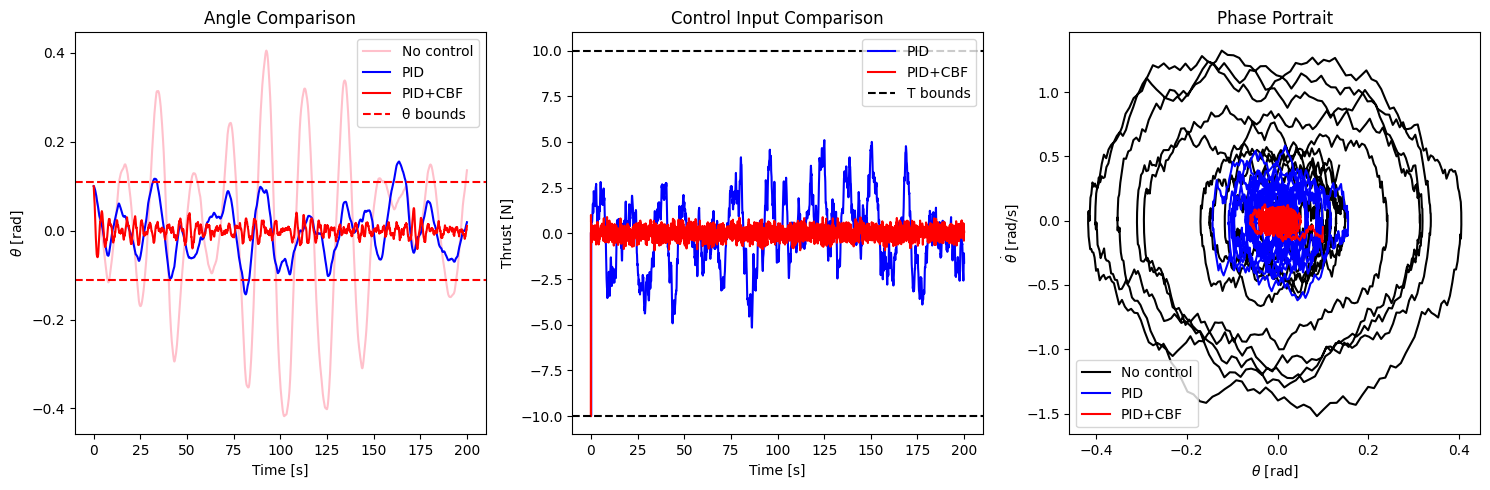

In [170]:
# Ensure time arrays match the lengths of the data arrays
t_noctrl = jnp.linspace(0, T_sim, xs_fixed_wind.shape[0])          # N+1
t_pid = jnp.linspace(0, T_sim, pid_fixed_states.shape[0])          # N+1
t_pidcbf = jnp.linspace(0, T_sim, CBF_pid_fixed_states.shape[0])   # N+1
t_controls = jnp.linspace(0, T_sim, pid_fixed_controls.shape[0])   # N

plt.figure(figsize=(15, 5))

# --- Angle comparison plot ---
plt.subplot(1, 3, 1)
plt.plot(t_noctrl, xs_fixed_wind[:, 0], 'k-',color = "pink", label='No control')
plt.plot(t_pid, pid_fixed_states[:, 0], 'b-', label='PID')
plt.plot(t_pidcbf, CBF_pid_fixed_states[:, 0], 'r-', label='PID+CBF')
plt.axhline(y=theta_max, color='r', linestyle='--', label='θ bounds')
plt.axhline(y=-theta_max, color='r', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta$ [rad]')
plt.title('Angle Comparison')
plt.legend()

# --- Control input comparison plot ---
plt.subplot(1, 3, 2)
plt.plot(t_controls, pid_fixed_controls, 'b-', label='PID')
plt.plot(t_pidcbf, CBF_pid_fixed_controls, 'r-', label='PID+CBF')
plt.axhline(y=T_max_abs, color='k', linestyle='--', label='T bounds')
plt.axhline(y=-T_max_abs, color='k', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Thrust [N]')
plt.title('Control Input Comparison')
plt.legend()

# --- Phase portrait plot (θ vs θ̇) ---
plt.subplot(1, 3, 3)
plt.plot(xs_fixed_wind[:, 0], xs_fixed_wind[:, 1], 'k-', label='No control')
plt.plot(pid_fixed_states[:, 0], pid_fixed_states[:, 1], 'b-', label='PID')
plt.plot(CBF_pid_fixed_states[:, 0], CBF_pid_fixed_states[:, 1], 'r-', label='PID+CBF')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\dot{\theta}$ [rad/s]')
plt.title('Phase Portrait')
plt.legend()

plt.tight_layout()
plt.show()


In [173]:
import jax.numpy as jnp
from jax import jit, grad, lax, random
from functools import partial

# Constants
T_max_abs = 10.0
v_wind_abs_max = 30.0  # Example wind magnitude
dt = 0.01
T_sim = 200
m = 1.0    # mass
g = 9.81   # gravity
l0 = 1.0   # fixed pendulum length
C_d = 0.1  # drag coefficient

# CBF: Safe set is θ in [-0.2, 0.2]
def h(x):
    return 0.04 - x[0]**2

# Dynamics for testing (pendulum with wind drag)
def dynamics_fixed(x, u, d):
    theta, theta_dot = x
    thrust = u[0]
    v_wind = d[0]
    theta_ddot = (thrust/(m*l0) - g/l0*jnp.sin(theta) + 
                 C_d/(m*l0)*(v_wind - l0*theta_dot))
    return jnp.array([theta_dot, theta_ddot])

# Drift and control vector fields
def drift_field(x):
    return dynamics_fixed(x, jnp.array([0.0]), jnp.array([0.0]))

def control_field(x):
    return dynamics_fixed(x, jnp.array([1.0]), jnp.array([0.0])) - f(x)

# Ellipsoidal CBF-safe filter
def cbf_safe_filter(f, g, h, x, u_nom, kappa=1.0, epsilon=0.1, u_bounds=(-T_max_abs, T_max_abs)):
    Lf_h = jnp.dot(grad(h)(x), f(x))
    Lg_h = jnp.dot(grad(h)(x), g(x))
    Lg_norm_sq = jnp.dot(Lg_h, Lg_h)
    rhs = -kappa * h(x) + (1.0 / epsilon) * Lg_norm_sq

    def constraint(u):
        return jnp.dot(Lg_h, u) + Lf_h - rhs

    def projected_update(u):
        adjustment = 0.1 * (Lg_h / (jnp.linalg.norm(Lg_h)**2 + 1e-6)) * (rhs - jnp.dot(Lg_h, u) - Lf_h)
        return u + adjustment

    u = u_nom
    for _ in range(10):
        u = lax.cond(constraint(u) < 0, projected_update, lambda u: u, u)
        u = jnp.clip(u, u_bounds[0], u_bounds[1])
    
    return u

# RK4 integrator
@partial(jit, static_argnums=(0,))
def rk4_step(f, x, u, d, dt):
    k1 = f(x, u, d)
    k2 = f(x + 0.5 * dt * k1, u, d)
    k3 = f(x + 0.5 * dt * k2, u, d)
    k4 = f(x + dt * k3, u, d)
    return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# CBF + PID controller wrapper
def CBF_PID_controller(dynamics, f, g, h, x0, dt, T_final, Kp=5.0, Ki=20.0, Kd=10.0, key=random.PRNGKey(42)):
    N = int(T_final / dt)

    @partial(jit, static_argnames=['dynamics', 'N'])
    def _pid_inner(dynamics, x0, dt, Kp, Ki, Kd, key, N):
        wind_samples = random.uniform(key, (N,), minval=-v_wind_abs_max, maxval=v_wind_abs_max)

        def safe_pid_step(carry, i):
            x, integral, prev_error = carry
            v_wind = wind_samples[i]
            d = jnp.array([v_wind])

            # PID computation
            error = -x[0]
            integral = jnp.clip(integral + error * dt, -1.0, 1.0)
            derivative = (error - prev_error) / dt
            u_pid = Kp * error + Ki * integral + Kd * derivative
            u_pid = jnp.clip(u_pid, -T_max_abs, T_max_abs)

            # Apply CBF safe filter
            u_safe = cbf_safe_filter(f, g, h, x, u_pid)

            x_next = rk4_step(dynamics, x, jnp.array([u_safe]), d, dt)

            return (x_next, integral, error), (x_next, u_safe, error)

        init_state = (x0, 0.0, 0.0)
        (_, _, _), (state_hist, control_hist, error_hist) = lax.scan(safe_pid_step, init_state, jnp.arange(N))

        # Prepend initial state
        state_hist = jnp.concatenate([x0[jnp.newaxis], state_hist])
        control_hist = jnp.concatenate([jnp.array([0.0]), control_hist])
        error_hist = jnp.concatenate([jnp.array([0.0]), error_hist])

        return state_hist, control_hist, error_hist, wind_samples

    return _pid_inner(dynamics, x0, dt, Kp, Ki, Kd, key, N)

# Run simulation
CBF_pid_fixed_states, CBF_pid_fixed_controls, CBF_pid_fixed_error_history, CBF_pid_wind = CBF_PID_controller(
    dynamics_fixed,
    drift_field,
    control_field,
    h,
    x0=jnp.array([0.1, -0.05]),  # Initial state: [theta, theta_dot]
    dt=dt,
    T_final=T_sim
)

/var/folders/qs/76sxk8bx6y7d6061nqr8wgcm0000gq/T/ipykernel_6885/2448077542.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t_noctrl, xs_fixed_wind[:, 0], 'k-',color = "pink", label='No control')


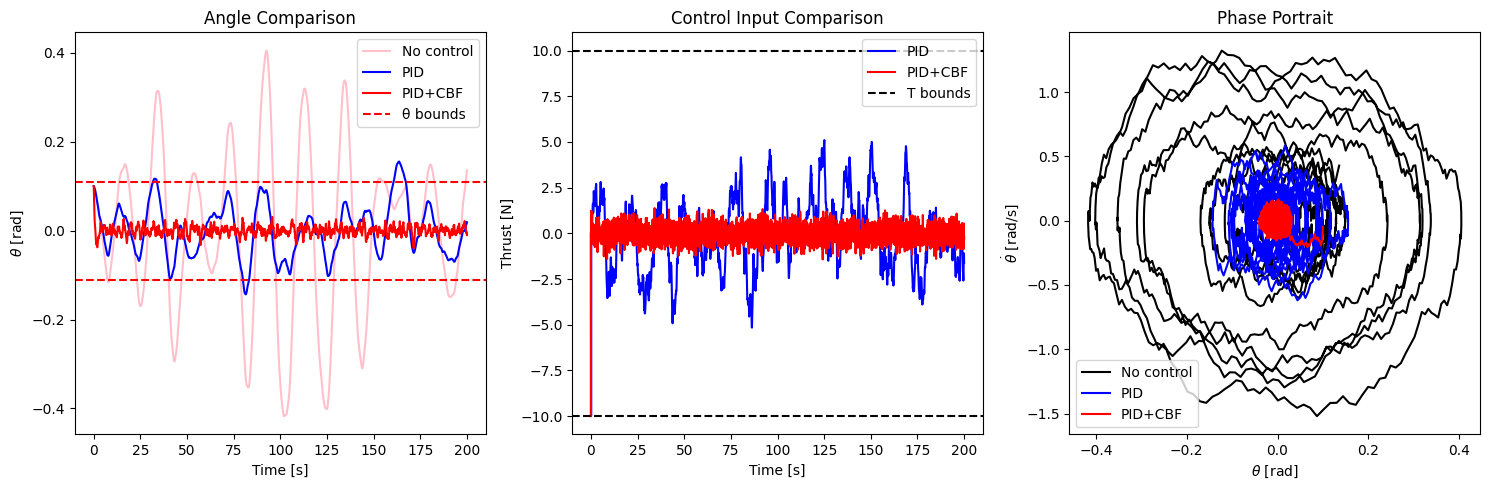

In [174]:
# Ensure time arrays match the lengths of the data arrays
t_noctrl = jnp.linspace(0, T_sim, xs_fixed_wind.shape[0])          # N+1
t_pid = jnp.linspace(0, T_sim, pid_fixed_states.shape[0])          # N+1
t_pidcbf = jnp.linspace(0, T_sim, CBF_pid_fixed_states.shape[0])   # N+1
t_controls = jnp.linspace(0, T_sim, pid_fixed_controls.shape[0])   # N

plt.figure(figsize=(15, 5))

# --- Angle comparison plot ---
plt.subplot(1, 3, 1)
plt.plot(t_noctrl, xs_fixed_wind[:, 0], 'k-',color = "pink", label='No control')
plt.plot(t_pid, pid_fixed_states[:, 0], 'b-', label='PID')
plt.plot(t_pidcbf, CBF_pid_fixed_states[:, 0], 'r-', label='PID+CBF')
plt.axhline(y=theta_max, color='r', linestyle='--', label='θ bounds')
plt.axhline(y=-theta_max, color='r', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta$ [rad]')
plt.title('Angle Comparison')
plt.legend()

# --- Control input comparison plot ---
plt.subplot(1, 3, 2)
plt.plot(t_controls, pid_fixed_controls, 'b-', label='PID')
plt.plot(t_pidcbf, CBF_pid_fixed_controls, 'r-', label='PID+CBF')
plt.axhline(y=T_max_abs, color='k', linestyle='--', label='T bounds')
plt.axhline(y=-T_max_abs, color='k', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Thrust [N]')
plt.title('Control Input Comparison')
plt.legend()

# --- Phase portrait plot (θ vs θ̇) ---
plt.subplot(1, 3, 3)
plt.plot(xs_fixed_wind[:, 0], xs_fixed_wind[:, 1], 'k-', label='No control')
plt.plot(pid_fixed_states[:, 0], pid_fixed_states[:, 1], 'b-', label='PID')
plt.plot(CBF_pid_fixed_states[:, 0], CBF_pid_fixed_states[:, 1], 'r-', label='PID+CBF')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\dot{\theta}$ [rad/s]')
plt.title('Phase Portrait')
plt.legend()

plt.tight_layout()
plt.show()
